# Empirical Model

This notebook builds the empirical model described in the proposal outline. The focus is a standard panel regression in financial economics with bank fixed effects and time fixed effects.

**Core idea:** banks with a more favorable deposit profile should see different NIM sensitivity to monetary tightening. We test this using an interaction between a bank-level deposit profile measure and a time-series tightening measure from the Fed funds rate (DFF).


## 1. Setup
We keep the setup lean and transparent, sticking to commonly used libraries.


In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS

# Use a writable cache directory for matplotlib
os.environ["MPLCONFIGDIR"] = ".mplcache"

# Display settings for quick checks
pd.set_option("display.max_columns", 200)
plt.rcParams.update({"figure.dpi": 250, "savefig.dpi": 300})


## 2. Load Data
We use the pre-processed Call Reports panel and the daily Fed funds rate series.


In [2]:
# Paths are relative to this notebook location
DATA_DIR = "../DATA"
FFIEC_PATH = f"{DATA_DIR}/ffiec_combined.csv"
DFF_PATH = f"{DATA_DIR}/DFF.csv"

# Load the combined FFIEC panel and DFF series
ffiec_raw = pd.read_csv(FFIEC_PATH)
dff_raw = pd.read_csv(DFF_PATH)

# Display for quick inspection
ffiec_raw


,Reporting Period End Date,IDRSSD,TOTAL ASSETS,TOTAL DEPOSITS,NET INTEREST INCOME,NON-INTEREST BEARING DEPOSITS,NONINTEREST-BEARING BALS&CURR&COIN,"INTEREST EXPENSE, INTEREST ON DEPOSI"
0,2010-03-31,1000052,278627,222041,2169,21738.0,11806,NaN
1,2010-03-31,1000100,1683333,1342926,15132,104848.0,22274,NaN
2,2010-03-31,1000276,231625,184424,1586,10976.0,4453,NaN
3,2010-03-31,1000511,124222,97694,1024,28240.0,4054,NaN
4,2010-03-31,1000557,21244,19066,189,2532.0,914,NaN
...,...,...,...,...,...,...,...,...
366173,2025-09-30,99853,51138,46492,1462,16793.0,1487,61.0
366174,2025-09-30,998648,194140,164557,4772,46759.0,3186,567.0
366175,2025-09-30,998657,108431,94491,3278,27082.0,917,1077.0
366176,2025-09-30,998844,1147111,953936,30880,142975.0,14293,6213.0


## 3. Clean Columns and Parse Dates
We standardize names and parse dates so downstream code stays simple.


In [3]:
def clean_col(name: str) -> str:
    # Normalize column names for consistent access
    name = name.strip().lower()
    name = re.sub(r"[^a-z0-9]+", "_", name)
    return name.strip("_")

ffiec = ffiec_raw.copy()
ffiec.columns = [clean_col(c) for c in ffiec.columns]

# Rename key columns to readable names
rename_map = {
    "reporting_period_end_date": "report_date",
    "idrssd": "bank_id",
    "total_assets": "total_assets",
    "total_deposits": "total_deposits",
    "net_interest_income": "net_interest_income",
    "interest_expense_interest_on_deposi": "interest_expense_deposits",
    "total_equity_capital_rcon3210": "equity_capital",
    "other_assets_rcon2160": "other_assets",
    "total_trading_assets_rcon3545": "trading_assets",
    "intangible_assets_rcon2143": "intangible_assets",
    "total_interest_income": "total_interest_income",
    "interest_and_fees_on_loans": "interest_on_loans",
}

ffiec = ffiec.rename(columns={k: v for k, v in rename_map.items() if k in ffiec.columns})

# Parse dates and coerce numeric columns
ffiec["report_date"] = pd.to_datetime(ffiec["report_date"], errors="coerce")
ffiec = ffiec.dropna(subset=["report_date", "bank_id"])

non_numeric = {"report_date", "bank_id"}
for c in ffiec.columns:
    if c in non_numeric:
        continue
    ffiec[c] = pd.to_numeric(ffiec[c], errors="coerce")

# Treat bank_id as a string for stable fixed effects
ffiec["bank_id"] = ffiec["bank_id"].astype(str)

ffiec


,report_date,bank_id,total_assets,total_deposits,net_interest_income,non_interest_bearing_deposits,noninterest_bearing_bals_curr_coin,interest_expense_deposits
0,2010-03-31,1000052,278627,222041,2169,21738.0,11806,NaN
1,2010-03-31,1000100,1683333,1342926,15132,104848.0,22274,NaN
2,2010-03-31,1000276,231625,184424,1586,10976.0,4453,NaN
3,2010-03-31,1000511,124222,97694,1024,28240.0,4054,NaN
4,2010-03-31,1000557,21244,19066,189,2532.0,914,NaN
...,...,...,...,...,...,...,...,...
366173,2025-09-30,99853,51138,46492,1462,16793.0,1487,61.0
366174,2025-09-30,998648,194140,164557,4772,46759.0,3186,567.0
366175,2025-09-30,998657,108431,94491,3278,27082.0,917,1077.0
366176,2025-09-30,998844,1147111,953936,30880,142975.0,14293,6213.0


## 4. Fed Funds Rate: Quarterly Tightening Measure
We convert daily DFF to quarterly averages, compute the quarter-over-quarter change,
and flag large changes for the triple interaction.


In [4]:
# Prepare DFF series
dff = dff_raw.copy()
dff["observation_date"] = pd.to_datetime(dff["observation_date"], errors="coerce")
dff = dff.dropna(subset=["observation_date"])

# Ensure DFF is numeric
if "DFF" in dff.columns:
    dff["DFF"] = pd.to_numeric(dff["DFF"], errors="coerce")

dff["quarter"] = dff["observation_date"].dt.to_period("Q")

# Quarterly average DFF
q_dff = (
    dff.groupby("quarter")["DFF"]
    .mean()
    .reset_index()
    .rename(columns={"DFF": "dff_q"})
)

# Scale FFR to basis points for interpretation
q_dff["dff_q_bps"] = q_dff["dff_q"] * 100

# Delta FFR in basis points
q_dff["delta_ffr"] = q_dff["dff_q_bps"].diff()

# Tightening dummy based on 4-quarter trend (25 bps threshold)
q_dff["tightening"] = (q_dff["dff_q_bps"] - q_dff["dff_q_bps"].shift(4) >= 25).astype(int)

q_dff

,quarter,dff_q,dff_q_bps,delta_ffr,tightening
0,2010Q1,0.133889,13.388889,NaN,0
1,2010Q2,0.191978,19.197802,5.808913,0
2,2010Q3,0.188804,18.880435,-0.317367,0
3,2010Q4,0.189565,18.956522,0.076087,0
4,2011Q1,0.154556,15.455556,-3.500966,0
...,...,...,...,...,...
59,2024Q4,4.647935,464.793478,-61.684783,0
60,2025Q1,4.330000,433.000000,-31.793478,0
61,2025Q2,4.330000,433.000000,0.000000,0
62,2025Q3,4.295652,429.565217,-3.434783,0


## 5. Merge Panel with DFF
Call Report dates are quarterly. We merge by quarter.


In [5]:
ffiec["quarter"] = ffiec["report_date"].dt.to_period("Q")

panel = ffiec.merge(q_dff, on="quarter", how="left")

panel

,report_date,bank_id,total_assets,total_deposits,net_interest_income,non_interest_bearing_deposits,noninterest_bearing_bals_curr_coin,interest_expense_deposits,quarter,dff_q,dff_q_bps,delta_ffr,tightening
0,2010-03-31,1000052,278627,222041,2169,21738.0,11806,NaN,2010Q1,0.133889,13.388889,NaN,0
1,2010-03-31,1000100,1683333,1342926,15132,104848.0,22274,NaN,2010Q1,0.133889,13.388889,NaN,0
2,2010-03-31,1000276,231625,184424,1586,10976.0,4453,NaN,2010Q1,0.133889,13.388889,NaN,0
3,2010-03-31,1000511,124222,97694,1024,28240.0,4054,NaN,2010Q1,0.133889,13.388889,NaN,0
4,2010-03-31,1000557,21244,19066,189,2532.0,914,NaN,2010Q1,0.133889,13.388889,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
366173,2025-09-30,99853,51138,46492,1462,16793.0,1487,61.0,2025Q3,4.295652,429.565217,-3.434783,0
366174,2025-09-30,998648,194140,164557,4772,46759.0,3186,567.0,2025Q3,4.295652,429.565217,-3.434783,0
366175,2025-09-30,998657,108431,94491,3278,27082.0,917,1077.0,2025Q3,4.295652,429.565217,-3.434783,0
366176,2025-09-30,998844,1147111,953936,30880,142975.0,14293,6213.0,2025Q3,4.295652,429.565217,-3.434783,0


## 6. Construct Variables
We follow the proposal definitions when possible:

- **NIM** = Net interest income / Total assets
- **DepositProfile** = Non-interest-bearing deposits / Total deposits (if available)
- **Tightening** = Quarterly change in DFF

If the exact non-interest-bearing deposit column is not available, we use a transparent proxy based on interest expense on deposits.


In [6]:
def find_column(cols, keywords):
    # Simple keyword search for column names
    for c in cols:
        if all(k in c for k in keywords):
            return c
    return None

# Base panel
panel = panel.copy()

# Winsorization helper (default ON)
WINSORIZE_DP = True
DP_LOW_P = 0.01
DP_HIGH_P = 0.99

def winsorize_series(s, low_p=0.01, high_p=0.99):
    lo, hi = s.quantile(low_p), s.quantile(high_p)
    return s.clip(lo, hi)


# Convert report date to year/quarter for YTD differencing
panel["report_year"] = panel["report_date"].dt.year
panel["report_quarter"] = panel["report_date"].dt.quarter

# Net Interest Income: convert YTD to quarterly flow (YTD -> quarterly)
panel = panel.sort_values(["bank_id", "report_date"]).copy()
panel["nii_ytd"] = panel["net_interest_income"]
panel["nii_ytd_lag"] = panel.groupby("bank_id")["nii_ytd"].shift(1)

panel["nii_quarterly"] = panel["nii_ytd"] - panel["nii_ytd_lag"]
# For Q1, YTD is already quarterly
panel.loc[panel["report_quarter"] == 1, "nii_quarterly"] = panel.loc[
    panel["report_quarter"] == 1, "nii_ytd"
]

# Average assets for scaling (avoid spikes)
panel["assets_lag"] = panel.groupby("bank_id")["total_assets"].shift(1)
panel["avg_assets"] = (panel["total_assets"] + panel["assets_lag"]) / 2

# NIM in basis points (quarterly, not annualized)
panel["nim"] = (panel["nii_quarterly"] / panel["avg_assets"]) * 10000

# Deposit profile (prefer explicit non-interest-bearing deposit series)
cols = list(panel.columns)
nonint_col = find_column(cols, ["non", "interest", "bearing", "deposit"])
if nonint_col is None:
    nonint_col = find_column(cols, ["non", "interest", "deposit"])

if nonint_col is None:
    raise ValueError(
        "No non-interest-bearing deposit column found. Ensure RCON6631 or equivalent is included."
    )

panel["noninterest_deposits"] = panel[nonint_col]
panel["deposit_profile"] = panel["noninterest_deposits"] / panel["total_deposits"]

# Bank-level (time-invariant) deposit profile as in the proposal equation
panel["deposit_profile_mean"] = panel.groupby("bank_id")["deposit_profile"].transform("mean")

# Apply winsorization to bank-level mean if enabled
if WINSORIZE_DP:
    panel["deposit_profile_used"] = winsorize_series(panel["deposit_profile_mean"], DP_LOW_P, DP_HIGH_P)
else:
    panel["deposit_profile_used"] = panel["deposit_profile_mean"]

# Controls (levels) per proposal: size and funding mix
panel["log_assets"] = np.log(panel["total_assets"])
panel["deposit_ratio"] = panel["total_deposits"] / panel["total_assets"]

panel

/Users/maxmalata/CODE/Erasmus/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,report_date,bank_id,total_assets,total_deposits,net_interest_income,non_interest_bearing_deposits,noninterest_bearing_bals_curr_coin,interest_expense_deposits,quarter,dff_q,dff_q_bps,delta_ffr,tightening,report_year,report_quarter,nii_ytd,nii_ytd_lag,nii_quarterly,assets_lag,avg_assets,nim,noninterest_deposits,deposit_profile,deposit_profile_mean,deposit_profile_used,log_assets,deposit_ratio
0,2010-03-31,1000052,278627,222041,2169,21738.0,11806,NaN,2010Q1,0.133889,13.388889,NaN,0,2010,1,2169,NaN,2169.0,NaN,NaN,NaN,21738.0,0.097901,0.196033,0.196033,12.537629,0.796911
7250,2010-06-30,1000052,279793,221572,4417,21270.0,3680,NaN,2010Q2,0.191978,19.197802,5.808913,0,2010,2,4417,2169.0,2248.0,278627.0,279210.0,80.512876,21270.0,0.095996,0.196033,0.196033,12.541805,0.791914
14402,2010-09-30,1000052,282023,227922,6651,22709.0,6391,NaN,2010Q3,0.188804,18.880435,-0.317367,0,2010,3,6651,4417.0,2234.0,279793.0,280908.0,79.527817,22709.0,0.099635,0.196033,0.196033,12.549744,0.808168
21496,2010-12-31,1000052,281827,219668,8984,24268.0,7283,NaN,2010Q4,0.189565,18.956522,0.076087,0,2010,4,8984,6651.0,2333.0,282023.0,281925.0,82.752505,24268.0,0.110476,0.196033,0.196033,12.549049,0.779443
28495,2011-03-31,1000052,279765,215186,2422,NaN,5354,NaN,2011Q1,0.154556,15.455556,-3.500966,0,2011,1,2422,8984.0,2422.0,281827.0,280796.0,86.254790,NaN,NaN,0.196033,0.196033,12.541705,0.769167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348203,2024-09-30,999935,691367,619223,17757,149371.0,9195,3133.0,2024Q3,5.264783,526.478261,-6.521739,0,2024,3,17757,11554.0,6203.0,693040.0,692203.5,89.612376,149371.0,0.241223,0.225812,0.225812,13.446426,0.895650
352746,2024-12-31,999935,711195,642507,24140,125573.0,7203,4342.0,2024Q4,4.647935,464.793478,-61.684783,0,2024,4,24140,17757.0,6383.0,691367.0,701281.0,91.019149,125573.0,0.195442,0.225812,0.225812,13.474702,0.903419
357265,2025-03-31,999935,744377,674155,6481,132155.0,10042,1183.0,2025Q1,4.330000,433.000000,-31.793478,0,2025,1,6481,24140.0,6481.0,711195.0,727786.0,89.050902,132155.0,0.196031,0.225812,0.225812,13.520303,0.905663
361742,2025-06-30,999935,757243,684739,13462,134065.0,10935,2374.0,2025Q2,4.330000,433.000000,0.000000,0,2025,2,13462,6481.0,6981.0,744377.0,750810.0,92.979582,134065.0,0.195790,0.225812,0.225812,13.537439,0.904253


## 7. Lagged Controls and Clean Sample
We use one-quarter lags for controls, consistent with typical panel setups.


In [7]:
panel = panel.sort_values(["bank_id", "report_date"]).copy()

# Deposit rate (defined in the proposal, kept for future use)
panel["interest_bearing_deposits"] = panel["total_deposits"] - panel["noninterest_deposits"]
panel["lag_interest_bearing_deposits"] = panel.groupby("bank_id")["interest_bearing_deposits"].shift(1)
panel["avg_interest_bearing_deposits"] = (
    panel["interest_bearing_deposits"] + panel["lag_interest_bearing_deposits"]
) / 2

if "interest_expense_deposits" in panel.columns:
    panel["deposit_rate"] = panel["interest_expense_deposits"] / panel["avg_interest_bearing_deposits"]

control_vars = [
    "log_assets",
    "deposit_ratio",
]

# Lag controls by one quarter to reduce simultaneity
for c in control_vars:
    panel[f"lag_{c}"] = panel.groupby("bank_id")[c].shift(1)

# Basic filters to keep the sample clean
panel = panel[(panel["total_assets"] > 0) & (panel["total_deposits"] > 0)]

# Drop rows with missing key variables
model_vars = [
    "nim",
    "deposit_profile_used",
    "tightening",
    "lag_log_assets",
    "lag_deposit_ratio",
]

panel = panel.replace([np.inf, -np.inf], np.nan)
panel_model = panel.dropna(subset=model_vars).copy()

# Simple summary
n_banks = panel_model["bank_id"].nunique()
qtrs = panel_model["quarter"].nunique()
print(f"Banks: {n_banks}, Quarters: {qtrs}, Observations: {len(panel_model):,}")


Banks: 7692, Quarters: 62, Observations: 351,460


In [8]:
def find_column(cols, keywords):
    # Simple keyword search for column names
    for c in cols:
        if all(k in c for k in keywords):
            return c
    return None

# Base panel
panel = panel.copy()

# Convert report date to year/quarter for YTD differencing
panel["report_year"] = panel["report_date"].dt.year
panel["report_quarter"] = panel["report_date"].dt.quarter

# Net Interest Income: convert YTD to quarterly flow (YTD -> quarterly)
panel = panel.sort_values(["bank_id", "report_date"]).copy()
panel["nii_ytd"] = panel["net_interest_income"]
panel["nii_ytd_lag"] = panel.groupby("bank_id")["nii_ytd"].shift(1)

panel["nii_quarterly"] = panel["nii_ytd"] - panel["nii_ytd_lag"]
# For Q1, YTD is already quarterly
panel.loc[panel["report_quarter"] == 1, "nii_quarterly"] = panel.loc[
    panel["report_quarter"] == 1, "nii_ytd"
]

# Average assets for scaling (avoid spikes)
panel["assets_lag"] = panel.groupby("bank_id")["total_assets"].shift(1)
panel["avg_assets"] = (panel["total_assets"] + panel["assets_lag"]) / 2

# NIM in basis points (quarterly, not annualized)
panel["nim"] = (panel["nii_quarterly"] / panel["avg_assets"]) * 10000

# Deposit profile (prefer explicit non-interest-bearing deposit series)
cols = list(panel.columns)
nonint_col = find_column(cols, ["non", "interest", "bearing", "deposit"])
if nonint_col is None:
    nonint_col = find_column(cols, ["non", "interest", "deposit"])

if nonint_col is None:
    raise ValueError(
        "No non-interest-bearing deposit column found. Ensure RCON6631 or equivalent is included."
    )

panel["noninterest_deposits"] = panel[nonint_col]
panel["deposit_profile"] = panel["noninterest_deposits"] / panel["total_deposits"]

# Bank-level (time-invariant) deposit profile as in the proposal equation
panel["deposit_profile_mean"] = panel.groupby("bank_id")["deposit_profile"].transform("mean")

# Controls (levels) per proposal: size and funding mix
panel["log_assets"] = np.log(panel["total_assets"])
panel["deposit_ratio"] = panel["total_deposits"] / panel["total_assets"]

panel

,report_date,bank_id,total_assets,total_deposits,net_interest_income,non_interest_bearing_deposits,noninterest_bearing_bals_curr_coin,interest_expense_deposits,quarter,dff_q,dff_q_bps,delta_ffr,tightening,report_year,report_quarter,nii_ytd,nii_ytd_lag,nii_quarterly,assets_lag,avg_assets,nim,noninterest_deposits,deposit_profile,deposit_profile_mean,deposit_profile_used,log_assets,deposit_ratio,interest_bearing_deposits,lag_interest_bearing_deposits,avg_interest_bearing_deposits,deposit_rate,lag_log_assets,lag_deposit_ratio
0,2010-03-31,1000052,278627,222041,2169,21738.0,11806,NaN,2010Q1,0.133889,13.388889,NaN,0,2010,1,2169,NaN,2169.0,NaN,NaN,NaN,21738.0,0.097901,0.196033,0.196033,12.537629,0.796911,200303.0,NaN,NaN,NaN,NaN,NaN
7250,2010-06-30,1000052,279793,221572,4417,21270.0,3680,NaN,2010Q2,0.191978,19.197802,5.808913,0,2010,2,4417,2169.0,2248.0,278627.0,279210.0,80.512876,21270.0,0.095996,0.196033,0.196033,12.541805,0.791914,200302.0,200303.0,200302.5,NaN,12.537629,0.796911
14402,2010-09-30,1000052,282023,227922,6651,22709.0,6391,NaN,2010Q3,0.188804,18.880435,-0.317367,0,2010,3,6651,4417.0,2234.0,279793.0,280908.0,79.527817,22709.0,0.099635,0.196033,0.196033,12.549744,0.808168,205213.0,200302.0,202757.5,NaN,12.541805,0.791914
21496,2010-12-31,1000052,281827,219668,8984,24268.0,7283,NaN,2010Q4,0.189565,18.956522,0.076087,0,2010,4,8984,6651.0,2333.0,282023.0,281925.0,82.752505,24268.0,0.110476,0.196033,0.196033,12.549049,0.779443,195400.0,205213.0,200306.5,NaN,12.549744,0.808168
28495,2011-03-31,1000052,279765,215186,2422,NaN,5354,NaN,2011Q1,0.154556,15.455556,-3.500966,0,2011,1,2422,8984.0,2422.0,281827.0,280796.0,86.254790,NaN,NaN,0.196033,0.196033,12.541705,0.769167,NaN,195400.0,NaN,NaN,12.549049,0.779443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348203,2024-09-30,999935,691367,619223,17757,149371.0,9195,3133.0,2024Q3,5.264783,526.478261,-6.521739,0,2024,3,17757,11554.0,6203.0,693040.0,692203.5,89.612376,149371.0,0.241223,0.225812,0.225812,13.446426,0.895650,469852.0,474031.0,471941.5,0.006639,13.448843,0.880601
352746,2024-12-31,999935,711195,642507,24140,125573.0,7203,4342.0,2024Q4,4.647935,464.793478,-61.684783,0,2024,4,24140,17757.0,6383.0,691367.0,701281.0,91.019149,125573.0,0.195442,0.225812,0.225812,13.474702,0.903419,516934.0,469852.0,493393.0,0.008800,13.446426,0.895650
357265,2025-03-31,999935,744377,674155,6481,132155.0,10042,1183.0,2025Q1,4.330000,433.000000,-31.793478,0,2025,1,6481,24140.0,6481.0,711195.0,727786.0,89.050902,132155.0,0.196031,0.225812,0.225812,13.520303,0.905663,542000.0,516934.0,529467.0,0.002234,13.474702,0.903419
361742,2025-06-30,999935,757243,684739,13462,134065.0,10935,2374.0,2025Q2,4.330000,433.000000,0.000000,0,2025,2,13462,6481.0,6981.0,744377.0,750810.0,92.979582,134065.0,0.195790,0.225812,0.225812,13.537439,0.904253,550674.0,542000.0,546337.0,0.004345,13.520303,0.905663


## 8. Minimal Figures
These plots are simple and paper-friendly.


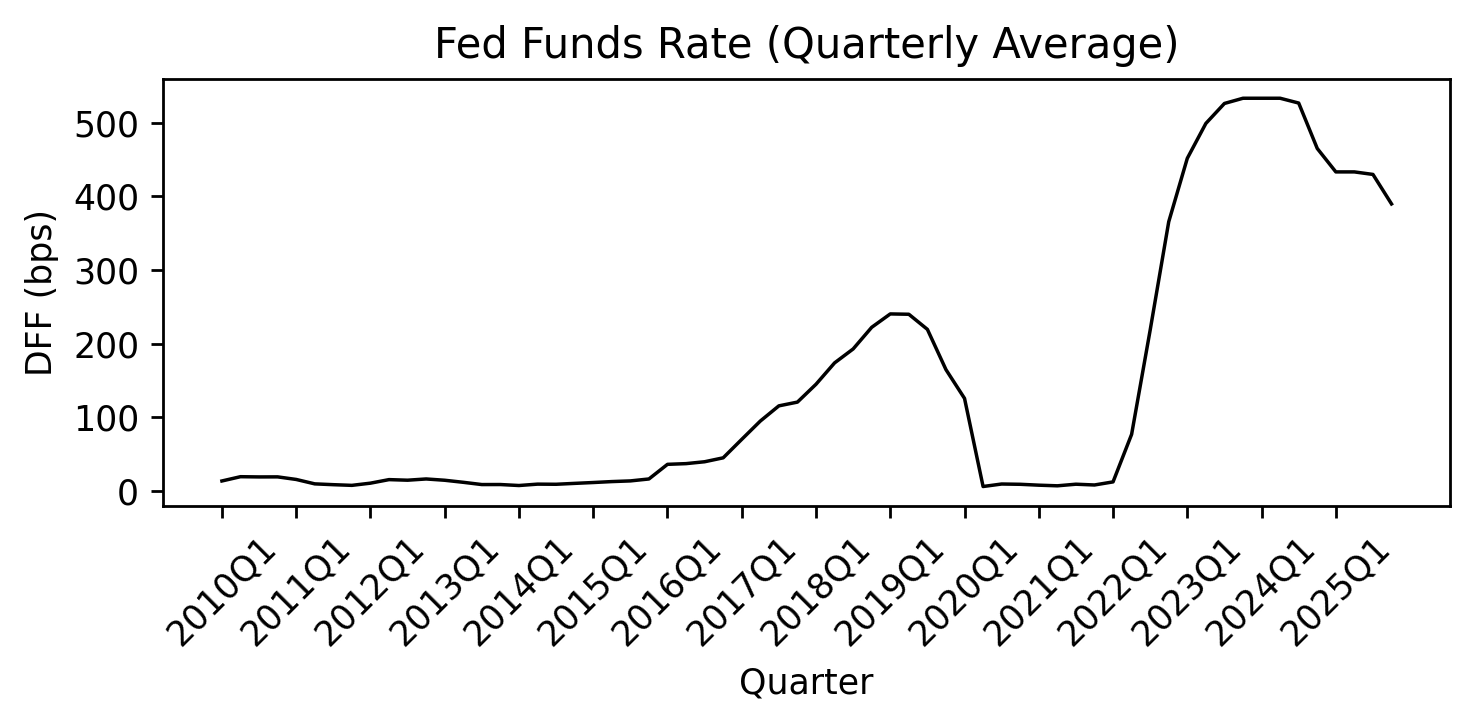

In [9]:
# Fed funds rate (quarterly average)
fig, ax = plt.subplots(figsize=(6, 3))

q_dff = q_dff.sort_values("quarter").reset_index(drop=True)

x_vals = q_dff["quarter"].astype(str)
ax.plot(range(len(x_vals)), q_dff["dff_q_bps"], color="black", lw=1)
ax.set_title("Fed Funds Rate (Quarterly Average)")
ax.set_xlabel("Quarter")
ax.set_ylabel("DFF (bps)")

# Only label Q1 of each year
q1_idx = [i for i, q in enumerate(x_vals) if q.endswith("Q1")]
ax.set_xticks(q1_idx)
ax.set_xticklabels([x_vals.iloc[i] for i in q1_idx])

ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

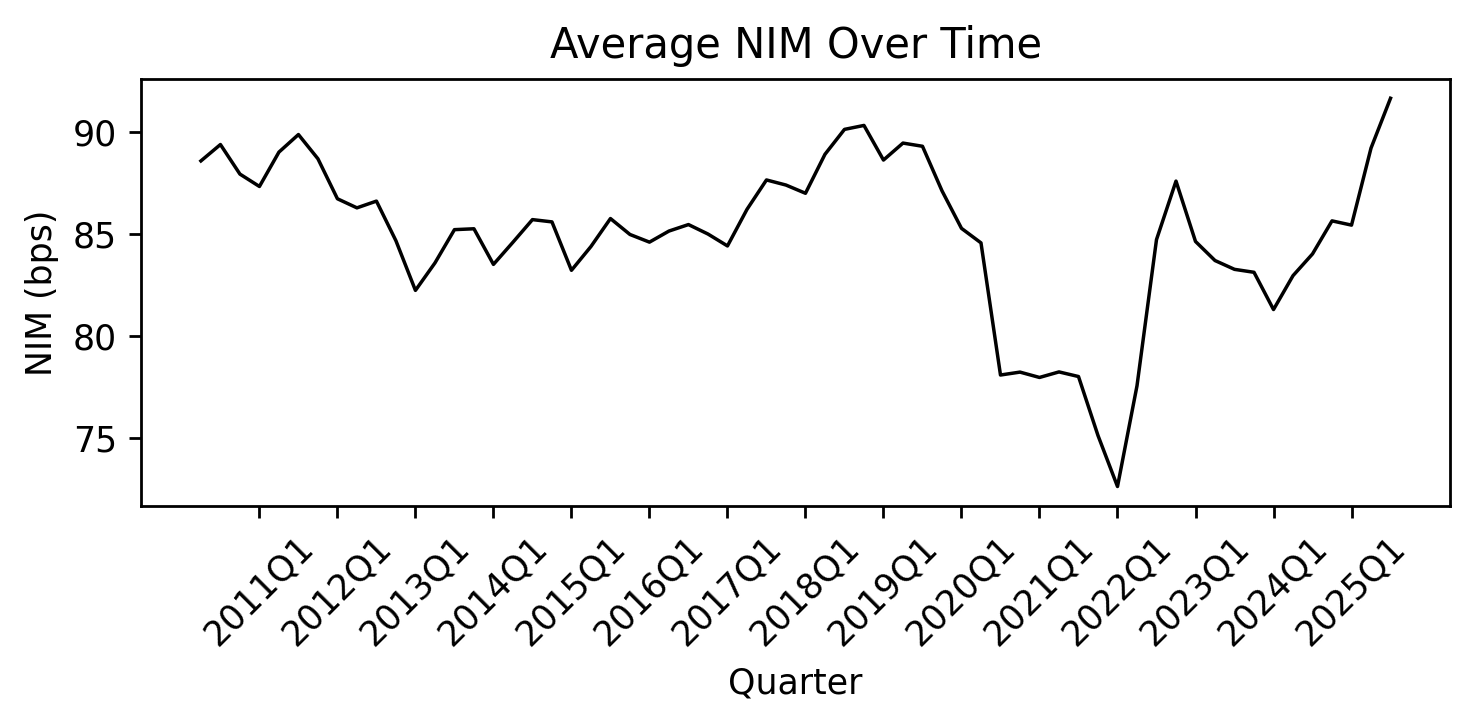

In [10]:
# Average NIM over time (full sample)
nim_by_q = panel_model.groupby("quarter")["nim"].mean().reset_index()

# Ensure chronological order
nim_by_q = nim_by_q.sort_values("quarter").reset_index(drop=True)

fig, ax = plt.subplots(figsize=(6, 3))

x_vals = nim_by_q["quarter"].astype(str)
ax.plot(range(len(x_vals)), nim_by_q["nim"], color="black", lw=1)
ax.set_title("Average NIM Over Time")
ax.set_xlabel("Quarter")
ax.set_ylabel("NIM (bps)")

# Only label Q1 of each year
q1_idx = [i for i, q in enumerate(x_vals) if q.endswith("Q1")]
ax.set_xticks(q1_idx)
ax.set_xticklabels([x_vals.iloc[i] for i in q1_idx])

ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

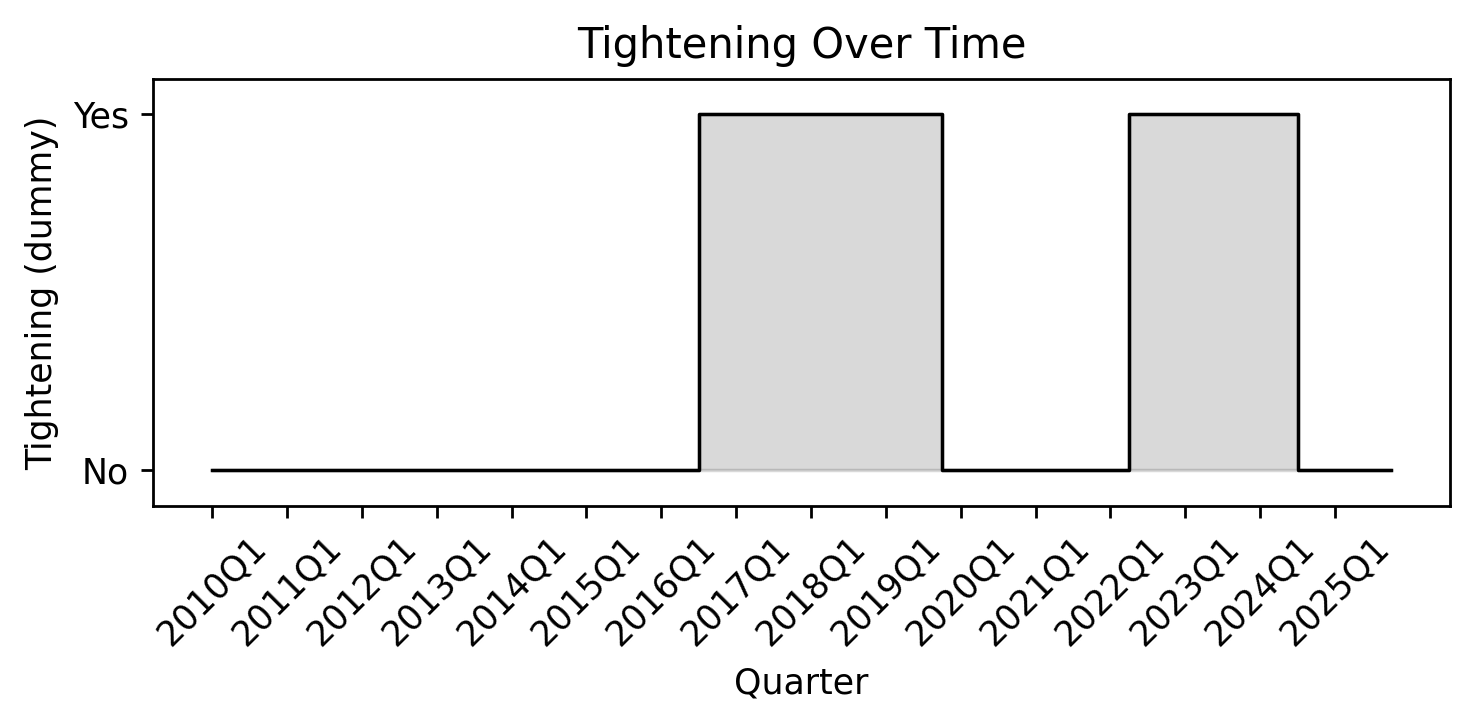

In [11]:
# Tightening over time (quarterly dummy)
fig, ax = plt.subplots(figsize=(6, 3))

q_dff = q_dff.sort_values("quarter").reset_index(drop=True)

x_vals = q_dff["quarter"].astype(str)
x_idx = range(len(x_vals))

ax.step(x_idx, q_dff["tightening"], where="post", color="black", lw=1)
ax.fill_between(x_idx, 0, q_dff["tightening"], step="post", color="black", alpha=0.15)
ax.set_title("Tightening Over Time")
ax.set_xlabel("Quarter")
ax.set_ylabel("Tightening (dummy)")

# Only label Q1 of each year
q1_idx = [i for i, q in enumerate(x_vals) if q.endswith("Q1")]
ax.set_xticks(q1_idx)
ax.set_xticklabels([x_vals.iloc[i] for i in q1_idx])

ax.set_yticks([0, 1])
ax.set_yticklabels(["No", "Yes"])
ax.set_ylim(-0.1, 1.1)

ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

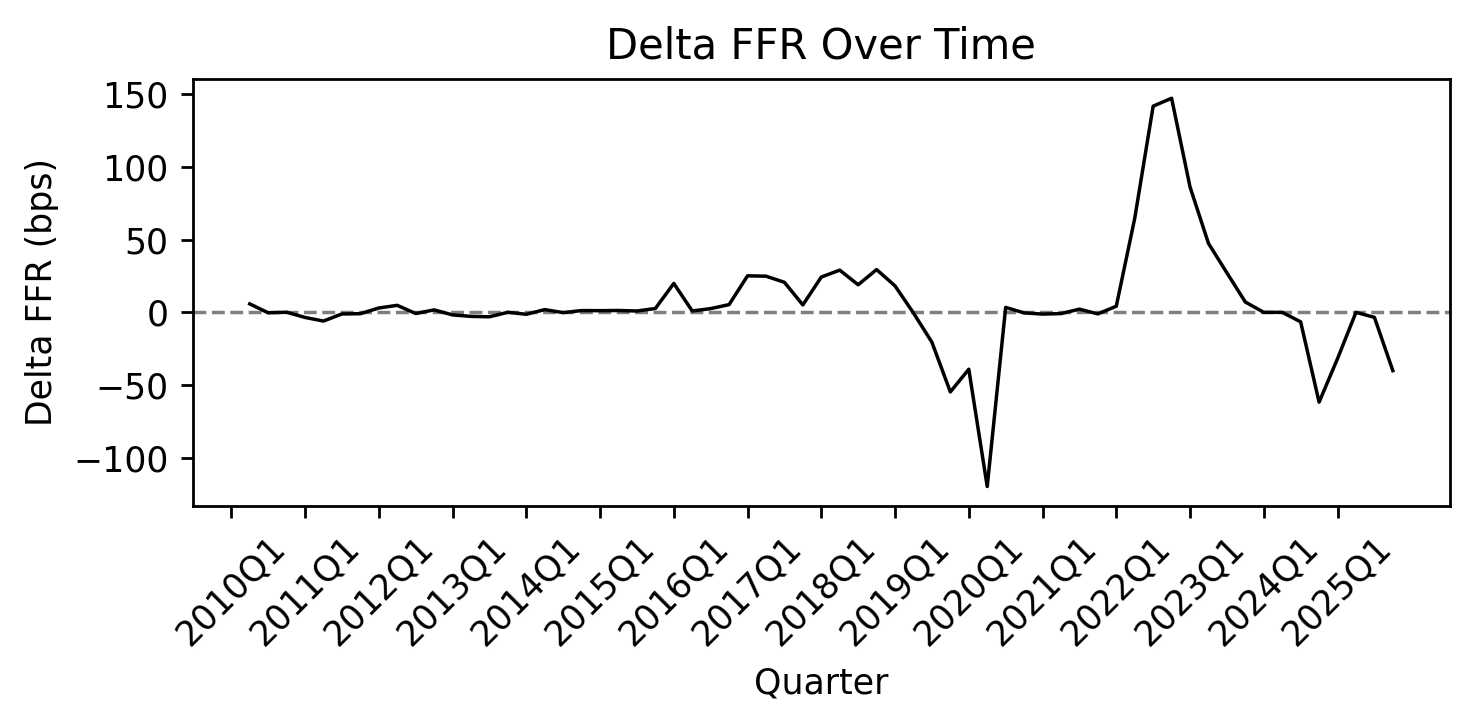

In [12]:
# Delta FFR over time (quarterly change)
fig, ax = plt.subplots(figsize=(6, 3))

q_dff = q_dff.sort_values("quarter").reset_index(drop=True)

x_vals = q_dff["quarter"].astype(str)
ax.plot(range(len(x_vals)), q_dff["delta_ffr"], color="black", lw=1)
ax.set_title("Delta FFR Over Time")
ax.set_xlabel("Quarter")
ax.set_ylabel("Delta FFR (bps)")
ax.axhline(0, color="black", lw=1, ls="--", alpha=0.5)

# Only label Q1 of each year
q1_idx = [i for i, q in enumerate(x_vals) if q.endswith("Q1")]
ax.set_xticks(q1_idx)
ax.set_xticklabels([x_vals.iloc[i] for i in q1_idx])

ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

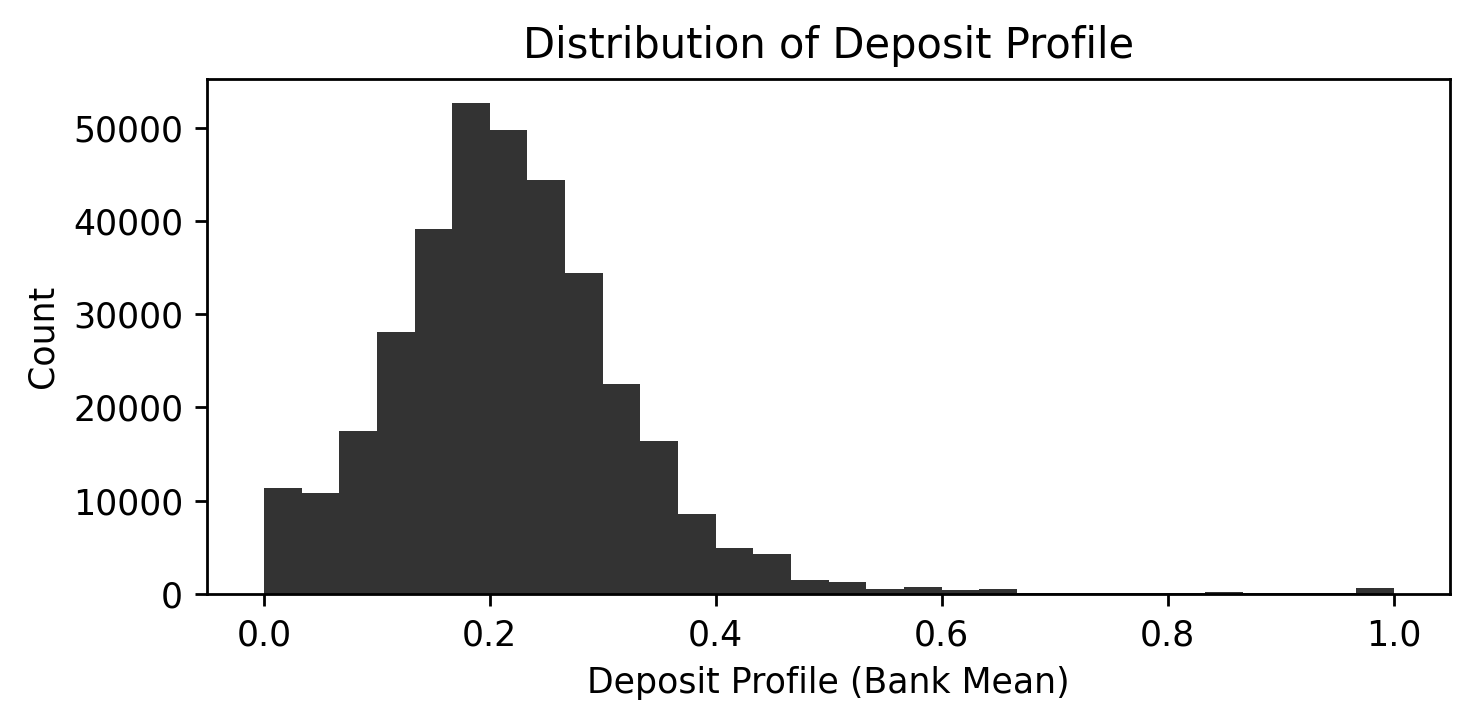

In [13]:
# Distribution of deposit profiles (bank means)
fig, ax = plt.subplots(figsize=(6, 3))

vals = panel_model["deposit_profile_mean"].dropna()
ax.hist(vals, bins=30, color="black", alpha=0.8)
ax.set_title("Distribution of Deposit Profile")
ax.set_xlabel("Deposit Profile (Bank Mean)")
ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

## 9. Empirical Model
Supervisor-adjusted panel specification:

```
NIM_it = alpha_i + delta_t + beta1 * DeltaFFR_t
         + beta2 * (DepositProfile_i × DeltaFFR_t)
         + beta3 * (DepositProfile_i × DeltaFFR_t × Tightening_t)
         + gamma X_{i,t-1} + epsilon_it
```

We estimate with bank and time fixed effects and cluster standard errors by bank.


In [14]:
panel_model = panel_model.copy()

# PanelOLS requires a date-like or numeric time index (quarter end dates)
panel_model["quarter_date"] = panel_model["quarter"].dt.to_timestamp("Q")

# Interaction terms
panel_model["dp_delta_ffr"] = panel_model["deposit_profile_used"] * panel_model["delta_ffr"]
panel_model["dp_delta_ffr_tight"] = panel_model["dp_delta_ffr"] * panel_model["tightening"]

# Panel index
panel_model = panel_model.set_index(["bank_id", "quarter_date"])

exog = panel_model[[
    "delta_ffr",
    "dp_delta_ffr",
    "dp_delta_ffr_tight",
    "lag_log_assets",
    "lag_deposit_ratio",
]]

mod = PanelOLS(panel_model["nim"], exog, entity_effects=True, time_effects=True, drop_absorbed=True)
res = mod.fit(cov_type="clustered", cluster_entity=True)

res.summary

/var/folders/b6/t3wdgmzx0q713dmw_h2wc3g00000gn/T/ipykernel_50761/1284657342.py:22: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

delta_ffr

  res = mod.fit(cov_type="clustered", cluster_entity=True)


Dep. Variable:,nim,R-squared:,0.0012
Estimator:,PanelOLS,R-squared (Between):,-0.2911
No. Observations:,351460,R-squared (Within):,0.0001
Date:,"Tue, Feb 03 2026",R-squared (Overall):,-0.2754
Time:,02:07:44,Log-likelihood,-1.54e+06
Cov. Estimator:,Clustered,,
,,F-statistic:,100.80
Entities:,7692,P-value,0.0000
Avg Obs:,45.692,Distribution:,"F(4,343703)"
Min Obs:,1.0000,,
Max Obs:,62.000,F-statistic (robust):,51.669


## 10. Notes for the Paper
- The interaction terms capture differential NIM sensitivity to monetary policy by deposit profile.
- "Delta FFR" is included as the main policy effect; with time fixed effects it is absorbed, but it keeps the specification explicit.
- Bank FE absorb time-invariant bank characteristics; time FE absorb common macro shocks.
- Controls are lagged to reduce simultaneity concerns.
- NIM is scaled by 10,000, so coefficients are in basis points.
- FFR and ΔFFR are scaled to basis points for interpretation.

If the deposit profile uses a proxy, we explicitly mention it and discuss limitations.

- Deposit profile mean is winsorized at the 1%/99% level (ON by default) to limit tail influence; this can shift coefficient magnitudes because the regressor's range is compressed.
- NIM is computed from quarterly (YTD-differenced) net interest income and scaled to basis points.
- FFR and ΔFFR are scaled to basis points; tightening is a 4-quarter increase of at least 25 bps.
- PanelOLS with bank and time fixed effects and bank-clustered standard errors replaces dummy-expanded OLS.